# Test hipy.efit


## Minimum -2LogLike Fits using strings

J. A. Hernando-Morata

05/04/2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
import hipy.pltext as pltext
import hipy.utils  as ut
import hipy.efit   as efit

pltext.style()

## stats

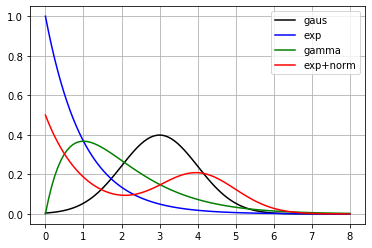

In [4]:
xs = np.linspace(0, 8., 100)

names = ['gaus', 'exp', 'gamma', 'exp+norm']
pars  = ((3., 1.), (1.,), (2.,), (1., 1., 1., 4., 1.)) 

for name, par in zip(names, pars):
    stat = efit.stat(name)
    plt.plot(xs, stat.pdf(xs, *par), label = name);
plt.legend(); plt.grid();

## MLL

In [5]:
def experiment(size, nbins, name,  pars0, mask = None, sigma = False, plot = False):

    is_composite = name.find('+') > 0
    isize         = 1 if is_composite else size
    
    stat = efit.stat(name)
    rv   = stat.rvs(*pars0, size = isize)
    
    y, edges = np.histogram(rv, nbins)
    x        = 0.5 *  (edges[1:] + edges[:-1])
    dx       = edges[1] - edges[0]
    p0       = np.copy(pars0)
    mask     = mask if mask is None else np.array(mask, bool)
    
    res = efit.mll(rv, name, p0 = p0, sigma = sigma, mask = mask)

    pars  = res.x
    upars = res.sigma if sigma else np.ones(len(pars))
    pulls = (pars - p0)/upars
    if (plot):
        pltext.hist(rv, nbins)
        plt.plot(x, size * dx * stat.pdf(x, *pars))
        if (mask is not None): print('mask  ', mask) 
        print('p0    ', *p0)
        print('pars  ', *pars)
        if (sigma):
            print('unc   ', *upars)
            print('pulls ', *pulls)
    
    return pars, upars, pulls


def plt_pulls(res, name, mask = None):
    
    parnames = efit.stat_argument_names(name)
    varnames = ['value', 'unc', 'pull']
    
    npars = len(res[0][0])
    nrows = npars if mask is None else np.sum(mask)
    
    subplot = pltext.canvas(nrows * 3, 3)

    k = 0
    for i in range(npars):
        if ((mask is not None) and (mask[i] == False)): continue
        for j in range(3):
            val = np.array([x[j][i] for x in res])
            #val = ut.remove_nan(val)
            if len(np.isfinite(val)) <= 0: continue
            val = val[np.isfinite(val)]
            subplot(k +  j + 1)
            pltext.hist(val, nbins)
            plt.xlabel(parnames[i] + ' ' + varnames[j])
        k += 3
    plt.tight_layout()

def test_pulls(nexp, size, nbins, name, pars0, sigma = False, mask = None):
        
    res = [experiment(size, nbins, name, pars0, sigma = sigma, mask = mask) for i in range(nexp)]
    
    plt_pulls(res, name, mask)

### Gaus

p0     0.0 1.0
pars   -0.01948435012082332 1.0136026010615382
unc    0.03209162657671633 0.02311030926890778
pulls  -0.6071474773721798 0.5885945057359713


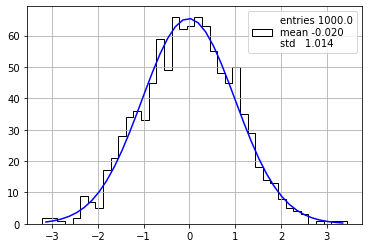

In [6]:
size, nbins  = 1000, 40
name, pars0   = 'normal', (0., 1.)
experiment(size, nbins, 'norm', pars0 = pars0, sigma = True, plot = True);

### Exponential

p0     5.0
pars   5.01776123046875
unc    0.5017761230468754
pulls  0.03539672306625632


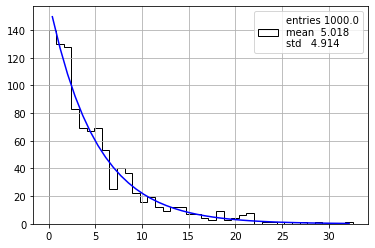

In [7]:
size, nbins  = 1000, 40
name, pars0  = 'exp', (5.,)

experiment(size, nbins, name, pars0, sigma = True, plot = True);

### Gamma

p0     5.0
pars   5.06207275390625
unc    0.5062072753906257
pulls  0.12262319591979437


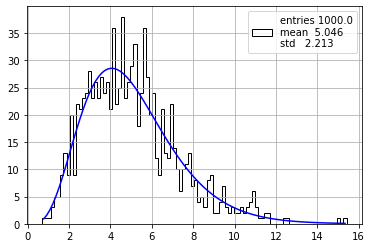

In [8]:
size, nbins = 1000, 100
name, pars0 = 'gamma', (5.,)
experiment(size, nbins, name, pars0, sigma = True, plot = True);

### Gaus Exponential

p0     1000.0 1.0 500.0 5.0 1.0
pars   993.3787090592274 0.9671688232103388 480.62133836084047 4.972237513212014 1.0156978099399514
unc    35.52162763990725 0.05617529479683325 27.155437303784367 0.06453551842287819 0.054546337792951816
pulls  -0.1864016764066811 -0.5844415575993019 -0.7136199436736351 -0.43018925804652763 0.2877885221100909


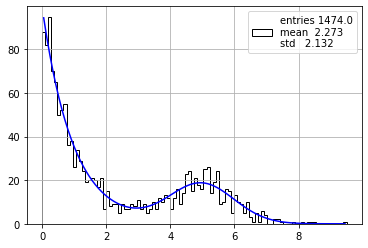

In [9]:
size1, size2, nbins  = 1000, 500, 100
name, pars0  = 'exp+norm', (size1, 1., size2, 5, 1.)
experiment(size1 + size2, nbins, name, pars0, sigma = True, plot = True);

## pulls

### Gaussian

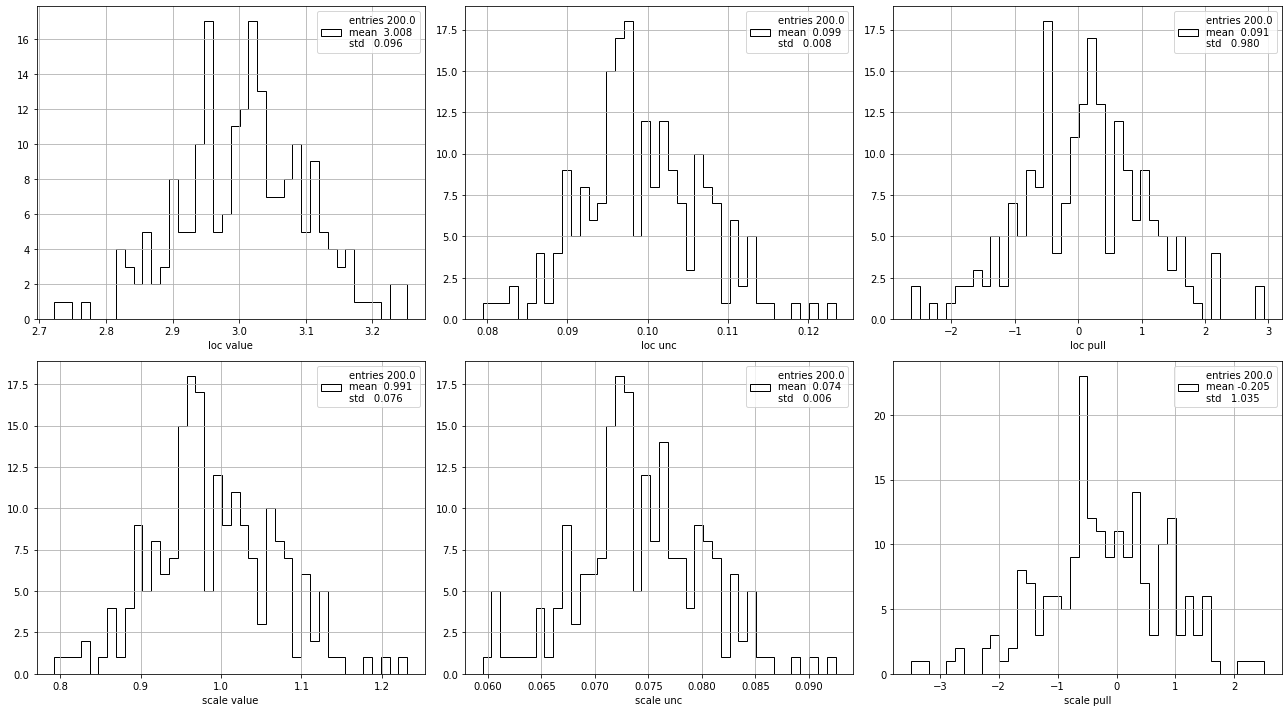

In [10]:
nexp, size, nbins = 200, 100, 40
name, pars        = 'norm', (3., 1.)
test_pulls(nexp, size, nbins, name, pars, sigma = True)

### Exponential

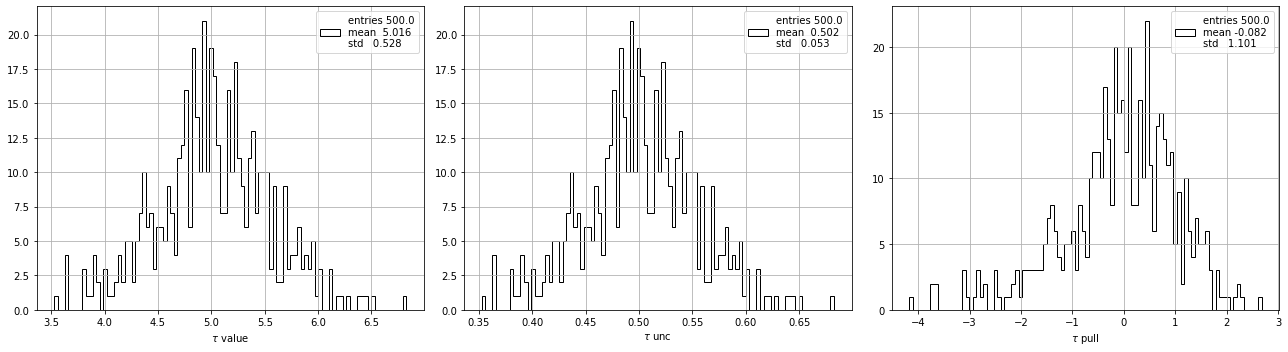

In [11]:
nexp, size, nbins = 500, 100, 100
name, pars        = 'exp', (5.,)
test_pulls(nexp, size, nbins, name, pars, sigma = True)

### Gamma

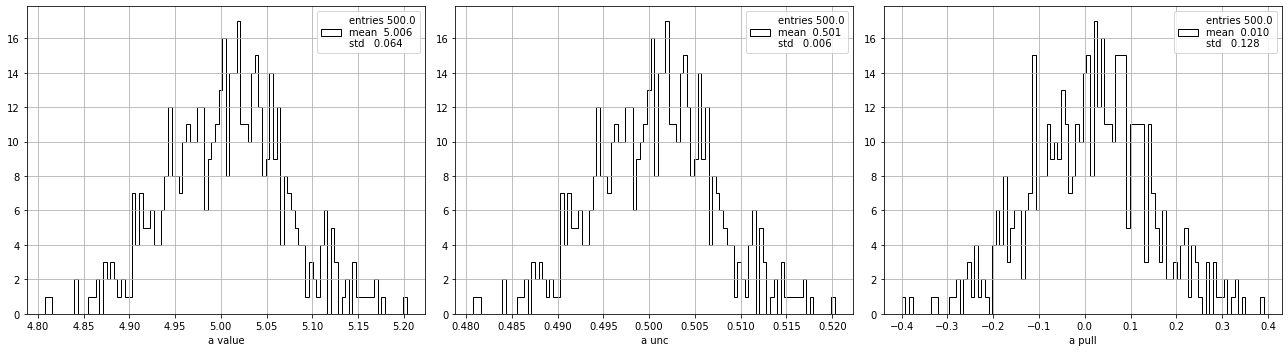

In [12]:
nexp, size, nbins = 500, 1000, 100
name, pars        = 'gamma', (5.,)
test_pulls(nexp, size, nbins, name, pars, sigma = True)

## Mask

### Gaussian

mask   [ True False]
p0     3.0 1.0
pars   3.0095947265625 1.0


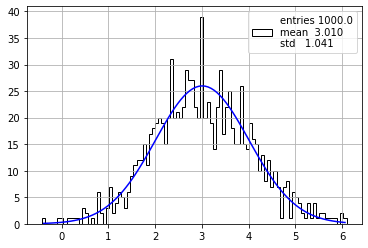

In [13]:
size, nbins = 1000, 100
name, pars0 = 'norm', (3., 1.)
mask        = (True, False)
experiment(size, nbins, name, pars0, mask = mask, plot = True);

mask   [False  True]
p0     3.0 1.0
pars   3.0 0.9891601562500001


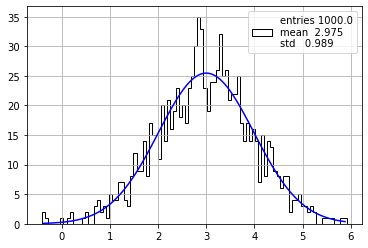

In [14]:
nexp, size, nbins = 500, 1000, 100
name, pars0      = 'norm', (3., 1.)
mask             = (False, True)
experiment(size, nbins, name, pars0, mask = mask, plot = True);

### Exponential + Norma

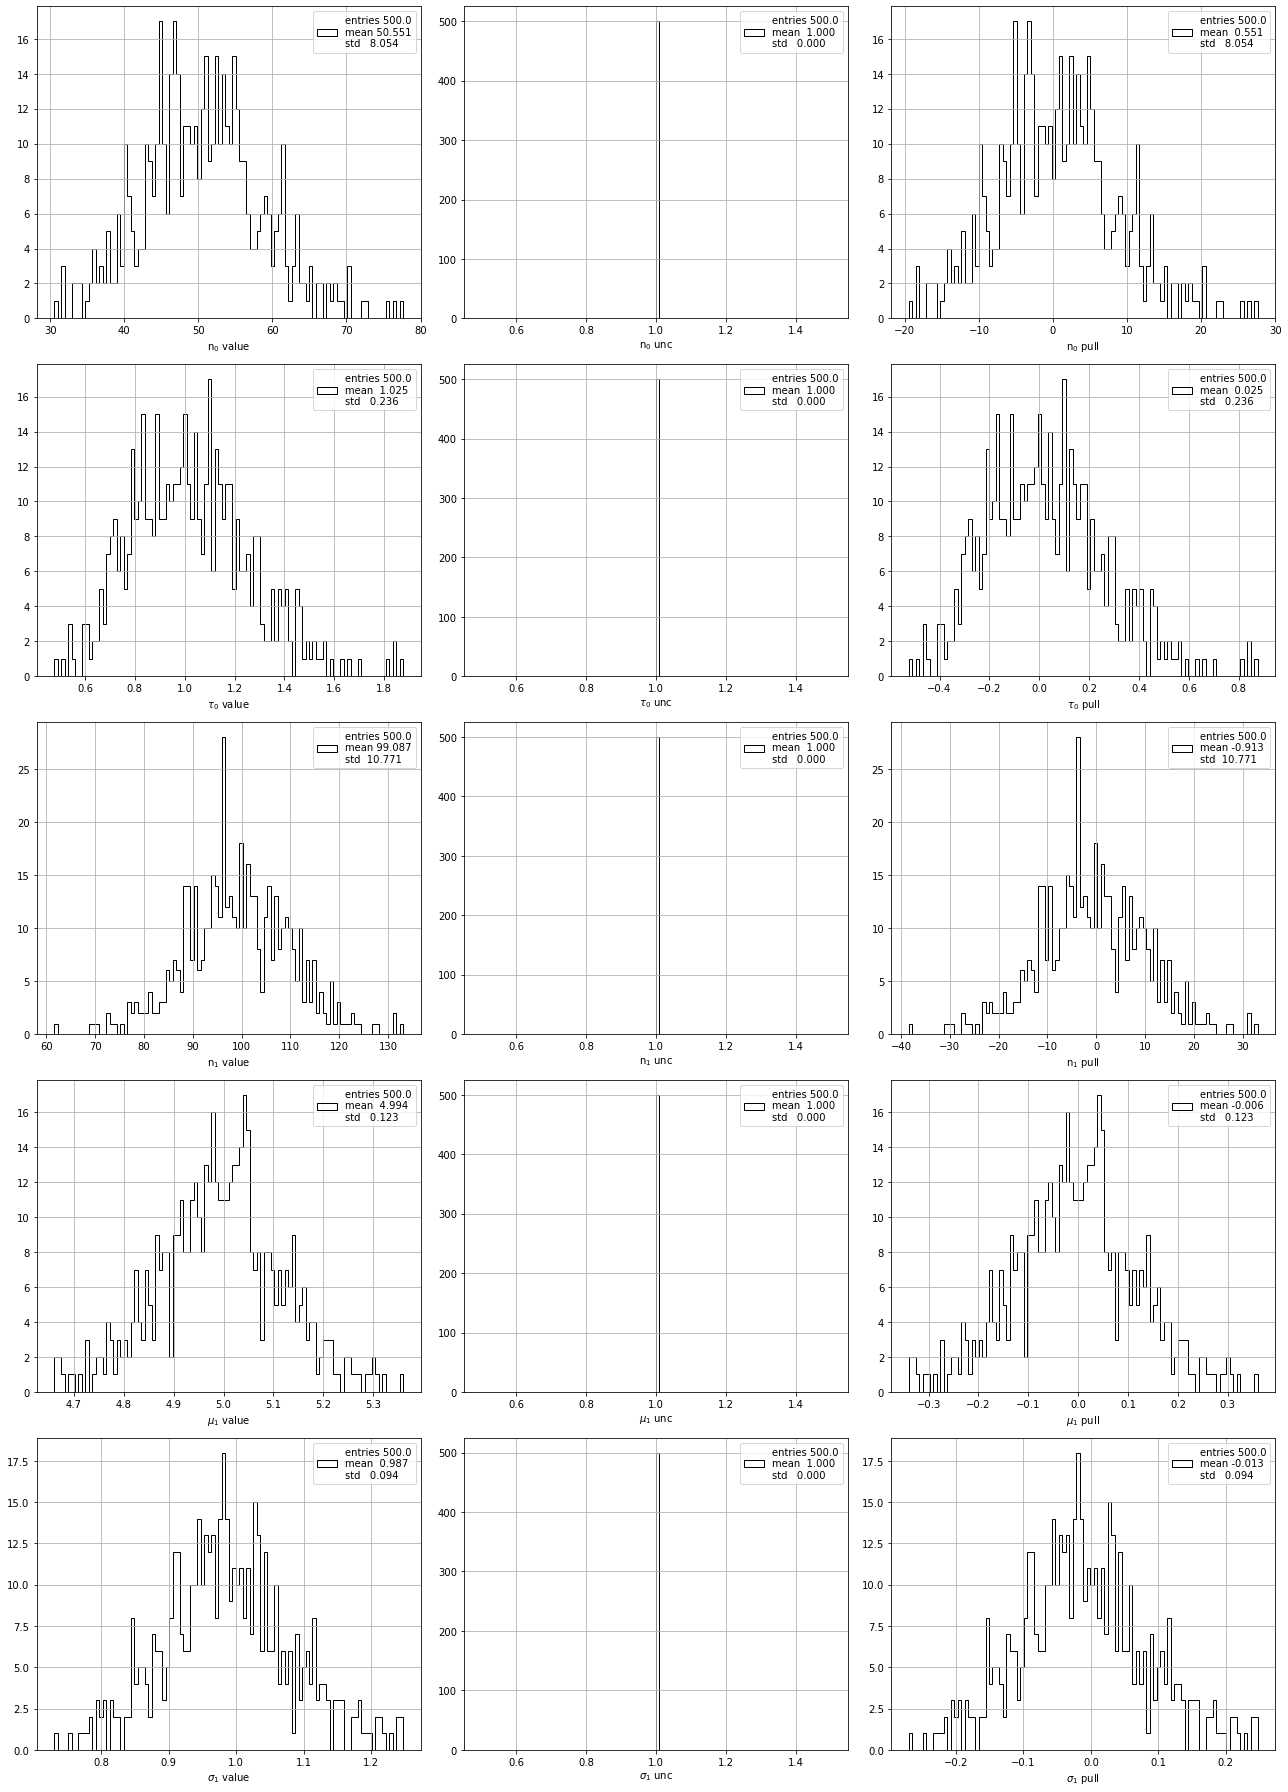

In [15]:
nexp                = 500
size1, size2, nbins = 50, 100, 100
name, pars0         = 'exp+gaus', (size1, 1, size2, 5., 1.)
mask                = (True, True, True, True, True)
test_pulls(nexp, size, nbins, name, pars0, mask = mask);

mask   [ True False  True False False]
p0     500.0 1.0 1000.0 5.0 1.0
pars   505.45537262136315 1.0 1045.5446263766955 5.0 1.0


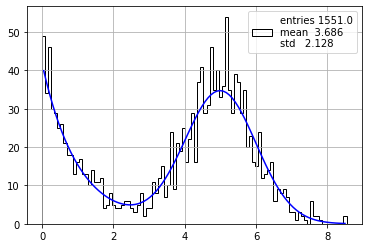

In [16]:
size1, size2, nbins = 500, 1000, 100
name, pars0         = 'exp+norm', (size1, 1, size2, 5., 1.)
mask                = (True, False, True, False, False)
experiment(size1 + size2, nbins, name, pars0, mask = mask, plot = True);

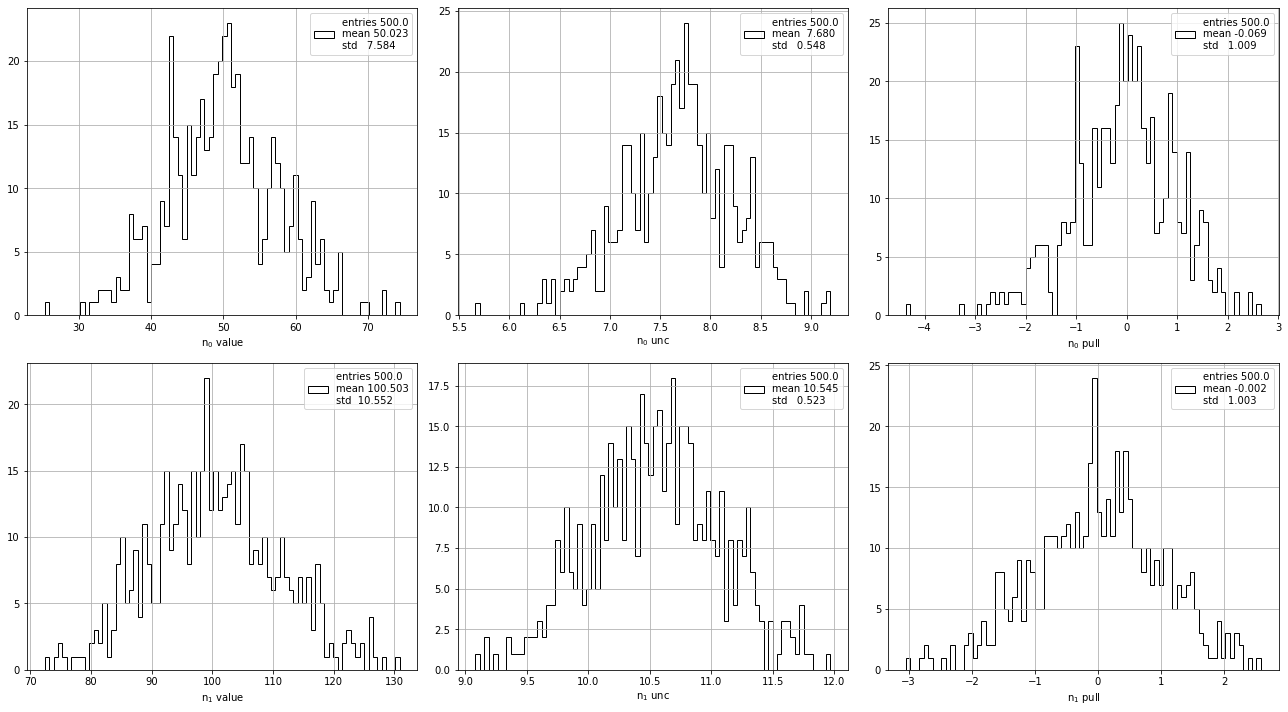

In [17]:
nexp                = 500
size1, size2, nbins = 50, 100, 80
name, pars0         = 'exp+gaus', (size1, 1, size2, 5., 1.)
mask                = (True, False, True, False, False)
test_pulls(nexp, size, nbins, name, pars0, sigma = True, mask = mask);

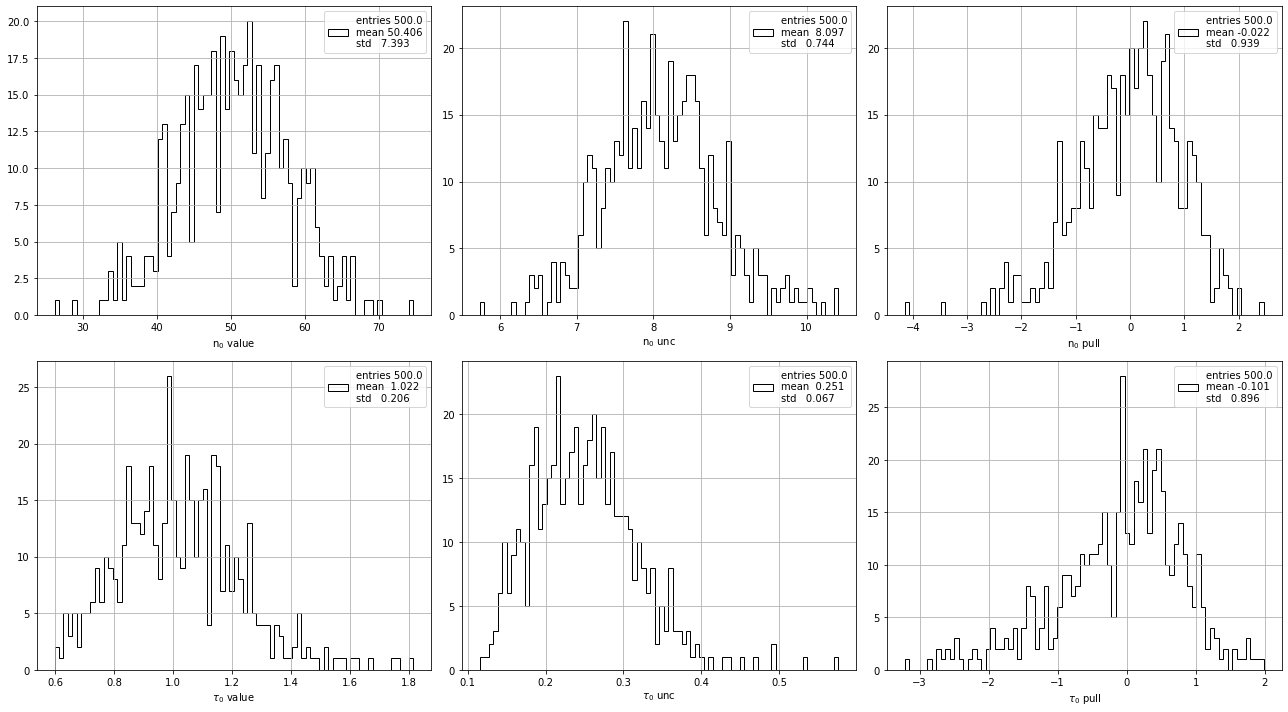

In [18]:
nexp                = 500
size1, size2, nbins = 50, 100, 80
name, pars0         = 'exp+gaus', (size1, 1, size2, 5., 1.)
mask                = (True, True, False, False, False)
test_pulls(nexp, size, nbins, name, pars0, sigma = True, mask = mask);

In [ ]:
nexp                = 100
size1, size2, nbins = 50, 100, 80
name, pars0         = 'exp+gaus', (size1, 1, size2, 5., 1.)
mask                = (False, False, True, True, True)
test_pulls(nexp, size, nbins, name, pars0, sigma = True, mask = mask);